In [1]:
"""
This programme can be used if you have bounding boxes on your validation set. 
If you have just tagged your validation set (classification way), refer to the other Monobloc_evaluator

"""

'\nThis programme can be used if you have bounding boxes on your validation set. \nIf you have just tagged your validation set (classification way), refer to the other Monobloc_evaluator\n\n'

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import numpy as np

import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import json

%matplotlib inline

In [3]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '../monoblocModels/v2-1/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '../TrainingPhase/model/monobloc_label_map.pbtxt'
print(PATH_TO_LABELS)
print(PATH_TO_CKPT)

NUM_CLASSES = 1


../TrainingPhase/model/monobloc_label_map.pbtxt
../monoblocModels/v2-1/frozen_inference_graph.pb


In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)


item {
  name: "monobloc chair"
  id: 1
}



In [6]:
def updt(total, progress, info):
    """
    Show how a loop progress


    Parameters
    ----------
    total : int 
    maximum of the loop
    
    progress : int 
    the iterator
    
    info : string
    name of the loading bar

    Returns
    -------
    a loading bar
    

    """
    progress=progress+1
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}%, filename {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text + info)
    sys.stdout.flush()

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    if (im_width*im_height,3)==np.array(image.getdata()).shape:
        return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)
    else:
        return []

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [8]:
def make_dict(boxes):
    #Change a list of list of coordinates into a list of bbox dictionnaries
    assert boxes!=[]
    list_dict=[]
    

    for box in boxes:
        assert box[0]<box[2]
        assert box[1]<box[3]
        n_dict = {'x1':box[0],'x2':box[2],'y1':box[1],'y2':box[3]}
        list_dict.append(n_dict)

    return list_dict

In [9]:
def reshape_error(filenames):
    #Function to call if load_image_into_numpy_array doesn't work
    for path in filenames:
        print("Reshape error with the file {}, it will be ignored".format(path))

        i=f_gt.index(path)
        f_gt.remove(path)
        del b_gt[i]

In [10]:
def import_json(path, limit=1310720):
    
    """
    Import filenames and bounding boxes from path 



    Parameters
    ----------
    path : string
    Path to valid.json
    
    limit : int
    It's the maximum number of pixels that an image should have. It's optional, in order to make this step faster and/or
    prevent your computer from a lack of GPU to run it

    Returns
    -------
    filenames : String list
    List of image path we want to import
    
    boxes : List of list of Dictionnaries
    List of Bounding boxes stocked in dictionnaries this way:
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    Each element from the first list is a list of predicted bounding box on one image

    """
    
    
    filenames=[]
    boxes=[]
    with open(path, 'r') as f:
        jload = json.load(f)
        
    for temp,data in enumerate(jload):
        
        seq=("../TrainingPhase/data", data["filename"])
        img_path="/".join(seq)
        updt(len(jload),temp,img_path)
        
        if (data["object"]=={}):
            filenames.append(img_path)
            boxes.append([{}])
            
        else :
            if (data["object"]["count"]==0):
                filenames.append(img_path)
                boxes.append([{}])
            else:
                b_list=[]
                nb_boxes=len(data["object"]["bbox"]["xmax"])
                if(data["height"]*data["width"]>=limit):
                    print("\n WARNING : picture {} is too big. We won't import this image".format(img_path))
                else:
                    for i in range (nb_boxes):
                        b_list.append([data["object"]["bbox"]["xmin"][i],data["object"]["bbox"]["ymin"][i],data["object"]["bbox"]["xmax"][i],data["object"]["bbox"]["ymax"][i]])
                    n_dict=make_dict(b_list)
                    filenames.append(img_path)
                    boxes.append(n_dict.copy())
         
            
            
    return filenames, boxes


In [11]:
def save_boxes_and_scores(image_paths, threshold=0.1):
    """
    make predictions of every images and return them 


    Parameters
    ----------
    image_paths : List of strings
    Path to images
    
    threshold : float between 0 and 1
    The minimum score limit. We keep every bounding box with a score higher than the threshold
    
    Returns
    -------
    list_filenames : String list
    List of image path we predicted
    
    list_boxes : List of list of dictionnaries
    List of Bounding boxes predicted per images, stocked in dictionnaries this way:
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    
    list_scores : List of list of float
    List of each prediction's scores per images

    """
    
    list_filenames=[]
    list_scores=[]
    list_boxes=[]
    error_file=[]
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            
            for temp,image_path in enumerate(image_paths):
                updt(len(image_paths),temp,image_path)
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                if len(image_np)==0:
                    error_file.append(image_path)
                    continue
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Actual detection.
                (boxes, scores, labels, num) = sess.run([detection_boxes, 
                                                          detection_scores, 
                                                          detection_classes, 
                                                          num_detections],feed_dict={image_tensor: image_np_expanded})
                #scores =[ [score classe 0] [score classe 1 ] etc... ]
                #boxes = [[bbox1] [bbox2] etc...]
                
                #On stocke la prédiction selon le seuil choisi dans s et b
                s=[]
                b=[]
                d={}
                for i in range (len(scores[0])): 
                    if (scores[0][i]>=threshold):
                        s.append(scores[0][i])
                        b.append(boxes[0][i]) #Format [left, top, right, bottom] NORMALIZED 
                if (b==[]):
                    d=[{}]
                else :
                    d=make_dict(b)
                list_scores.append(s.copy())
                list_boxes.append(d.copy())
                list_filenames.append(image_path)
                
            reshape_error(error_file)

                
    return list_filenames, list_scores, list_boxes

In [12]:
global f_gt
global b_gt

f_valid, b_valid = import_json("../TrainingPhase/data/valid.json")
f_test, b_test = import_json("../TrainingPhase/data/test.json")
f_gt=f_valid+f_test
b_gt=b_valid+b_test
filenames, scores, boxes = save_boxes_and_scores(f_gt,0.2)


[###-----------------] 17%, filename ../TrainingPhase/data/Images+json/img/monobloc (77)_6760dboL5z.pngg
[######--------------] 31%, filename ../TrainingPhase/data/Images+json/img/monobloc (314)_z2apqsxRkF.jpg
[######--------------] 32%, filename ../TrainingPhase/data/Images+json/img/monobloc (164)_NSjnRkzgMo.png
[#######-------------] 34%, filename ../TrainingPhase/data/Images+json/img/monobloc (43)_QajmCGKOhW.pngg
[##########----------] 48%, filename ../TrainingPhase/data/Images+json/img/monobloc (265)_ssnuoqVl21.jpg
[###############-----] 76%, filename ../TrainingPhase/data/Images+json/img/monobloc (118)_sg6WSNK6yS.png
[#################---] 83%, filename ../TrainingPhase/data/Images+json/img/monobloc (46)_FXSvX6YHPP.pngg
[##################--] 88%, filename ../TrainingPhase/data/Images+json/img/monobloc (119)_gsNGQWiEzE.png
[##################--] 92%, filename ../TrainingPhase/data/Images+json/img/monobloc (1)_apAZbeCjj3.pngng
[####################] 100%, filename ../TrainingPhase/

In [13]:
def img_classifier(b_gt):
    
    """
    Just to know how many positive images are present in the validation set:
    """
        
    imgpos=0
    imgneg=0

    for i in range (len(b_gt)):
        if b_gt[i]==[{}]:
            imgneg+=1
        else:
            imgpos+=1
    print(" The validation dataset contains {} positive images and {} negative images \n".format(imgpos, imgneg))

In [17]:
def img_posneg(filenames,scores,boxes1,boxes2,threshold=0.6):
    
    """
    calculate the number of True Positive, True Negative, False Positive and False Negative images

    Parameters
    ----------
    filenames : List of string
    List of every image path contained in the validation set
    
    scores : List of list of float
    List of list of predicted scores
    
    boxes1 : List of list of dictionnaries
    List of list of bounding boxes predicted, stocked in dictionnaries this way:
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
        
    boxes2 : List of list of dictionnaries
    List of list of groundtruth bounding boxes, stocked in dictionnaries this way:
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    
    Returns
    -------
    tp : int
    number of true positive boxes (boxes well predicted)
    
    fn : int
    number of false negative boxes (the researched object is present, but not found by the model)
    
    fp : int
    number of false positive boxes (object detected where there is nothing interesting)
    
    tn : int
    number of true negative boxes (no boxes predicted where there is no monobloc chair)
    
    error_path : list of string
    list of path where our model failed to predict
    
    error_reason : list of string
    list of string. strings are "false positive" or "false negative"
    
    """
    
    assert threshold<=1
    assert threshold>=0
     
    #boxes2 = b_gt and threshold is the value that determine know if the model identified a monobloc
    tp, fn, fp, tn = 0, 0, 0, 0
    error_path=[]
    error_reason=[]
    
    for i in range (len(filenames)):
        
        if (scores[i]==[]):
            if boxes2[i]==[{}]:
                tn+=1
            
            else:
                fn+=1
                error_reason.append("False negative image")
                error_path.append(filenames[i])
            
        else:
            if (scores[i][0]>threshold):
                if boxes2[i]!=[{}]:
                    tp+=1
                else:
                    fp+=1
                    error_reason.append("False positive image")
                    error_path.append(filenames[i])
            else :
                if boxes2[i]==[{}]:
                    tn+=1
                else:
                    fn+=1
                    error_reason.append("False negative image")
                    error_path.append(filenames[i])
                
    
    return tp, fn, fp, tn, error_path, error_reason
    

In [15]:
def print_pred(image_paths,titles, IMAGE_SIZE=(12, 8)):
    
    """
    Print with predicted bounding boxes, images where our model failed to predict correctly

    Parameters
    ----------
    image_paths : List of string
    List of path where our model failed the prediction
    
    titles : List of string
    List of reason of prediction failure

    """
    
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            temp=0
            for image_path, title in zip(image_paths, titles):
                updt(len(image_paths),temp,image_path)
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Actual detection.
                (boxes, scores, classes, num) = sess.run([detection_boxes, 
                                                          detection_scores, 
                                                          detection_classes, 
                                                          num_detections],feed_dict={image_tensor: image_np_expanded})
                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(image_np,
                                                                   np.squeeze(boxes),
                                                                   np.squeeze(classes).astype(np.int32),
                                                                   np.squeeze(scores),
                                                                   category_index,
                                                                   min_score_thresh=.2,
                                                                   use_normalized_coordinates=True,
                                                                   line_thickness=3)
                plt.figure(figsize=IMAGE_SIZE)
                plt.title(title)
                plt.imshow(image_np)
                temp+=1

 The validation dataset contains 289 positive images and 546 negative images 

[###############-----] 76%, filename ../TrainingPhase/data/Images+json/img/monobloc (335)_rRGxNpwsyQ.png

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[####################] 100%, filename ./TrainingPhase/data/Images+json/img/monobloc (346)_1XrPbGrUwY.jpg
../TrainingPhase/data/Images+json/img/monobloc (29)_wdBqpAuwDT.png
 Confusion Matrix about 'Is there at least one monobloc in this image?' with threshold score>0.8 : 
 Percentage of True Positive : 31.8562874251497% 
 Percentage of False Positive : 0.718562874251497% 
 Percentage of True Negative : 64.67065868263472% 
 Percentage of False Negative : 2.754491017964072%
Which means that 806 images well predicted against 29 miss predicted


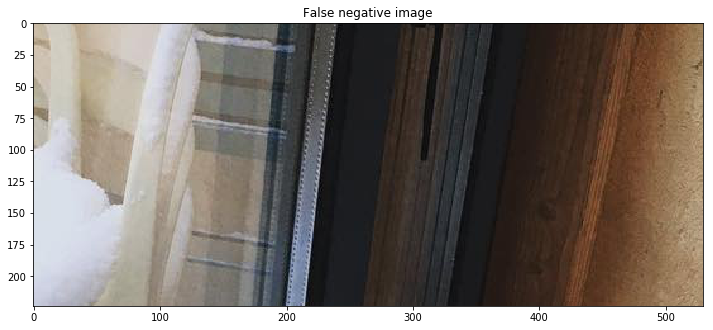

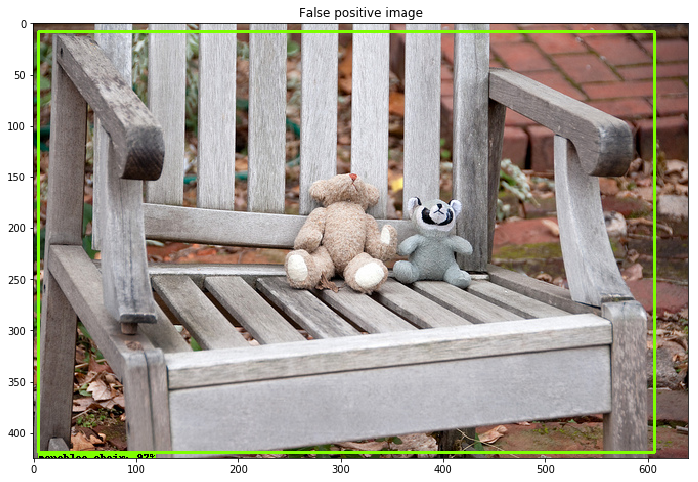

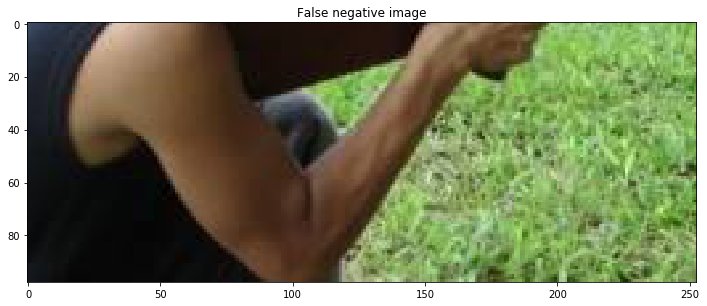

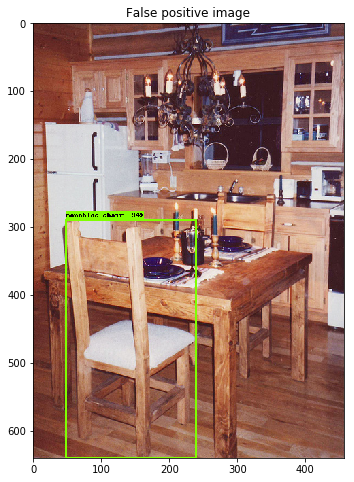

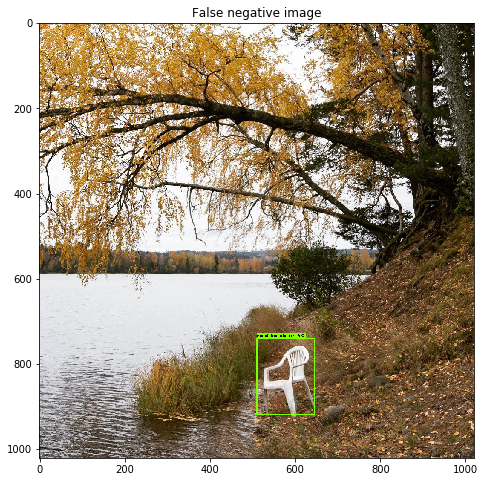

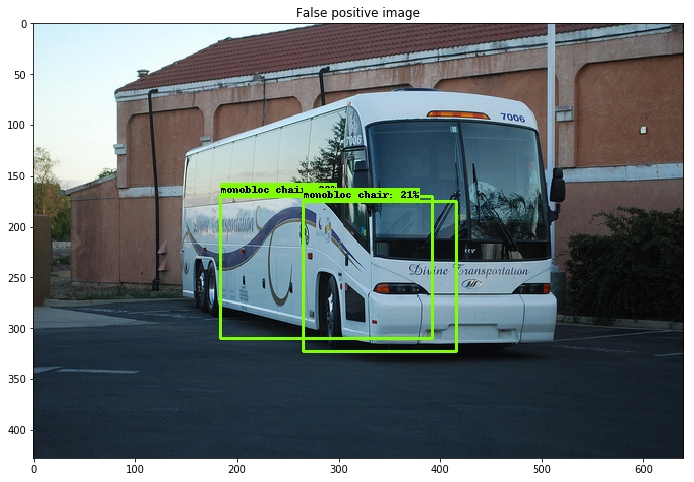

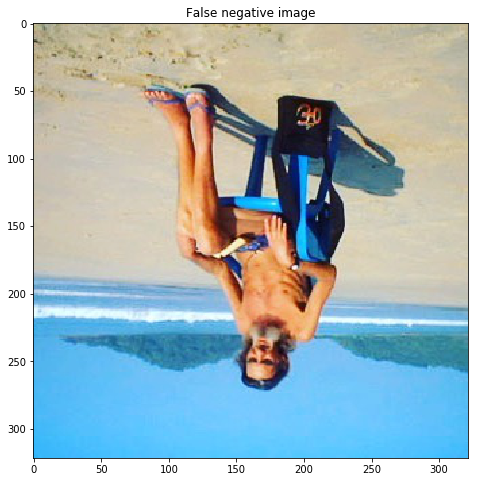

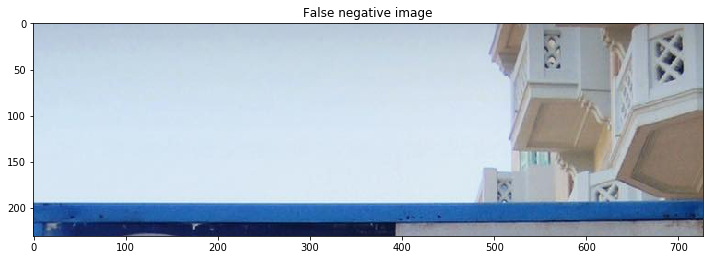

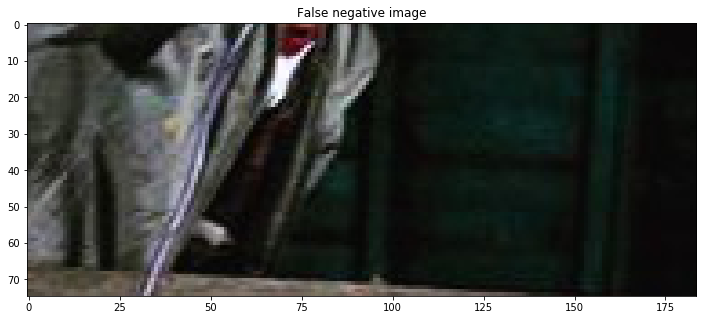

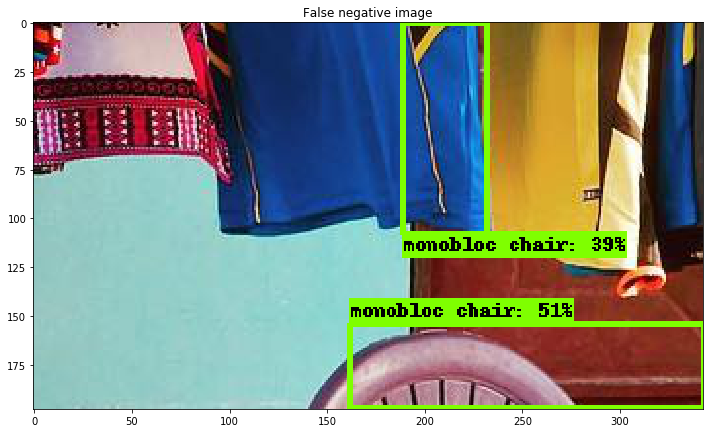

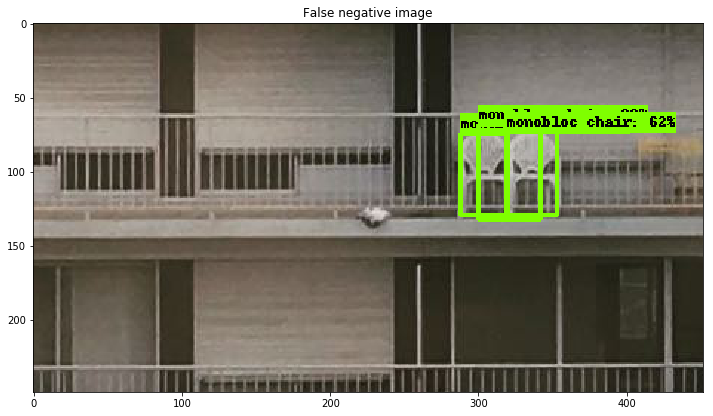

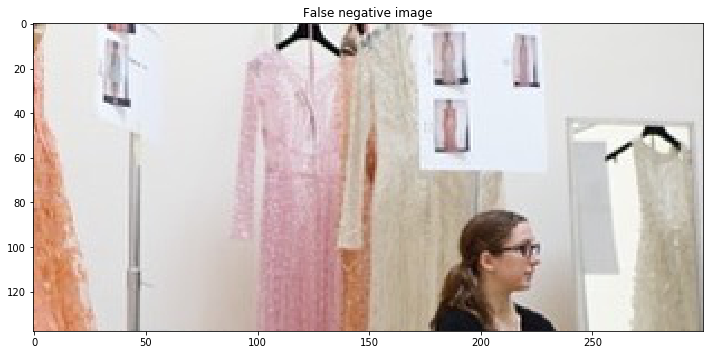

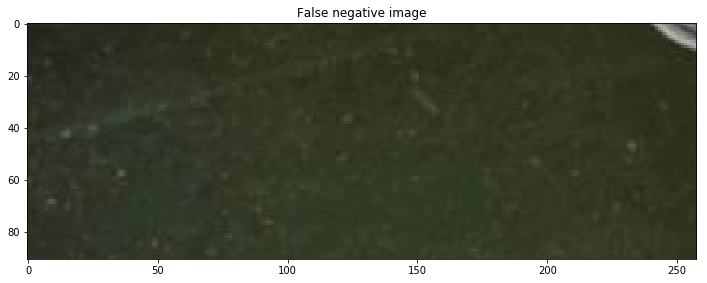

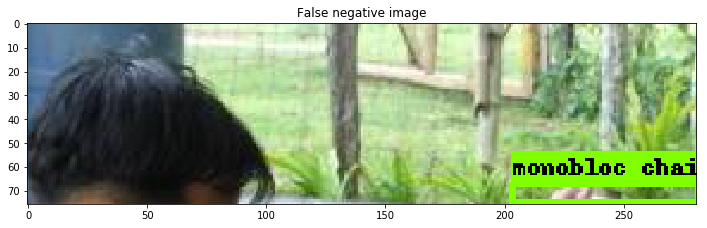

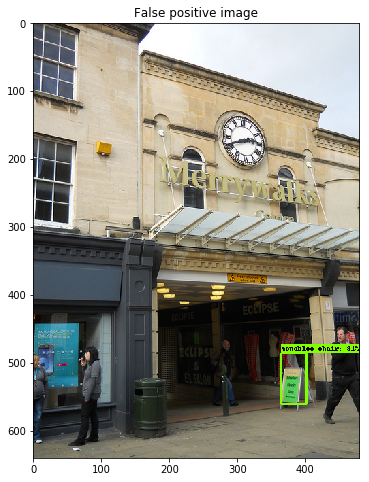

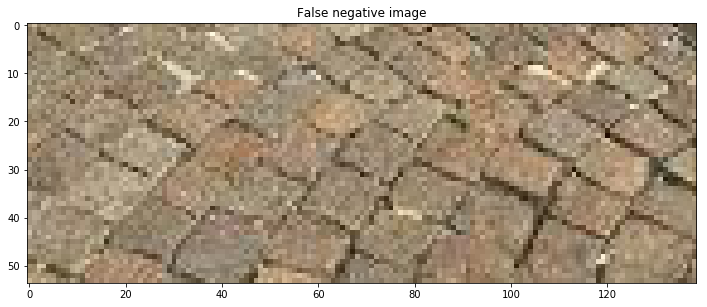

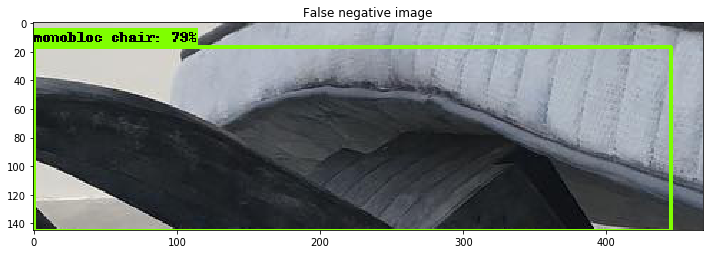

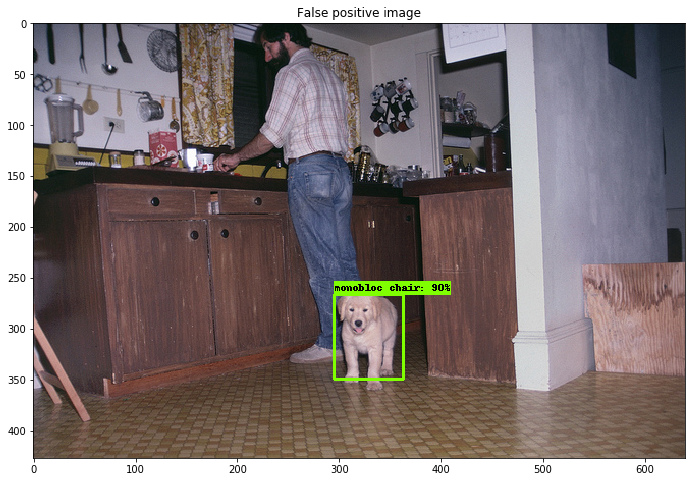

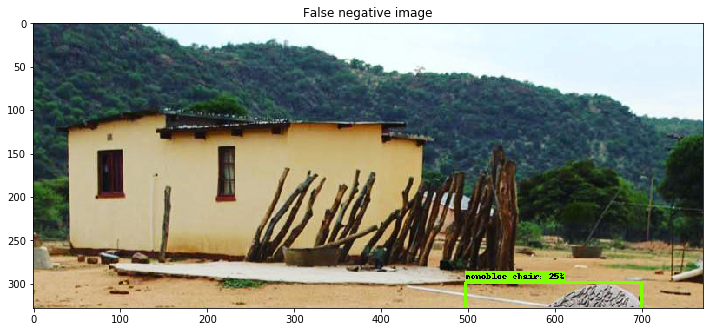

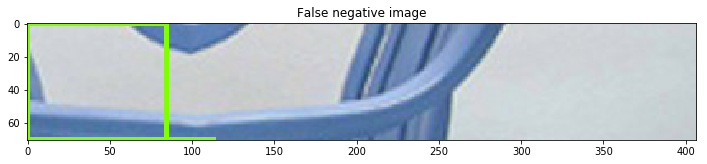

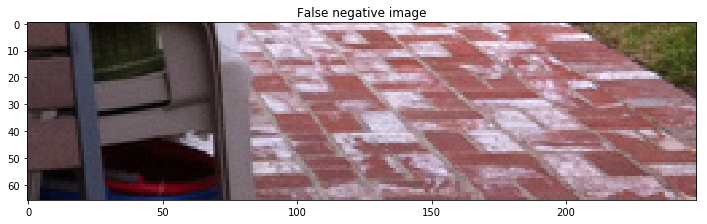

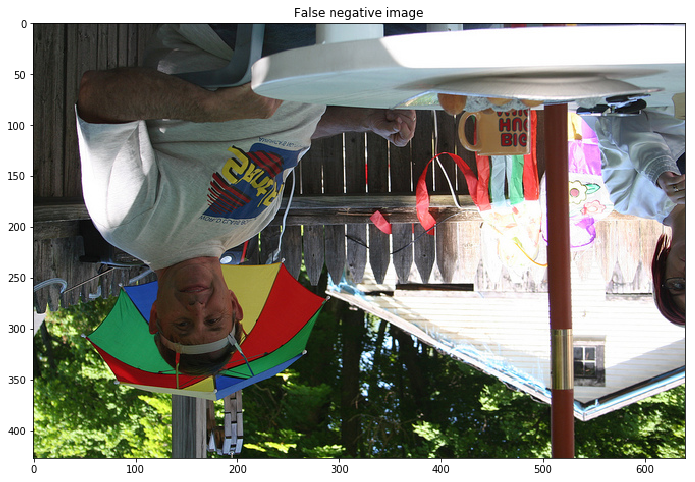

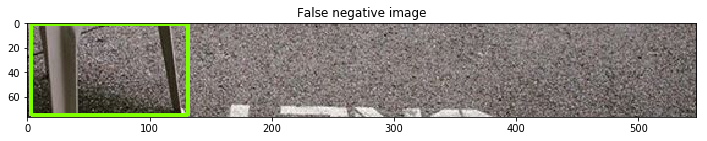

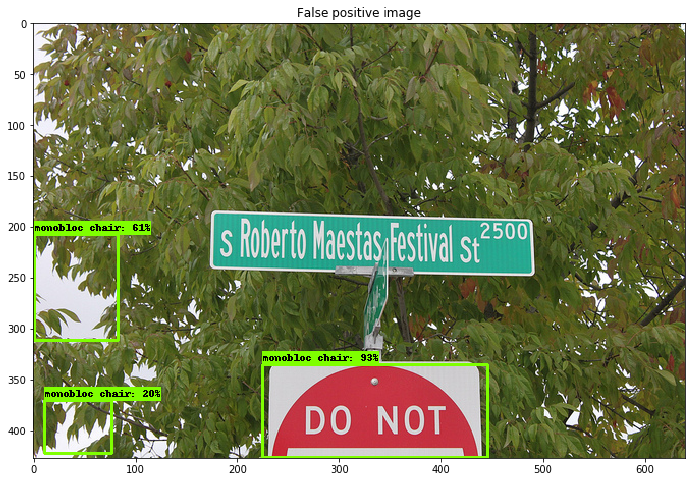

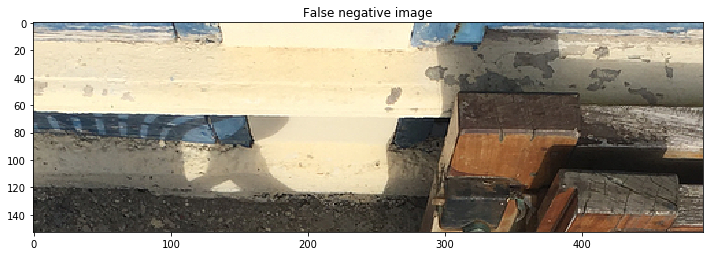

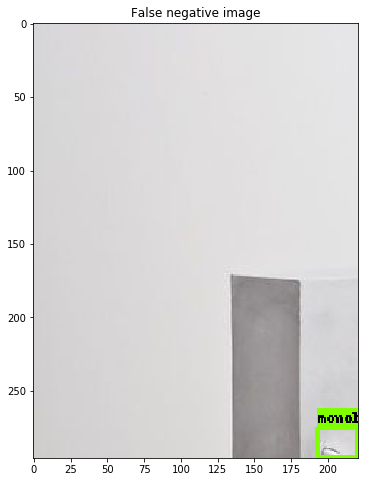

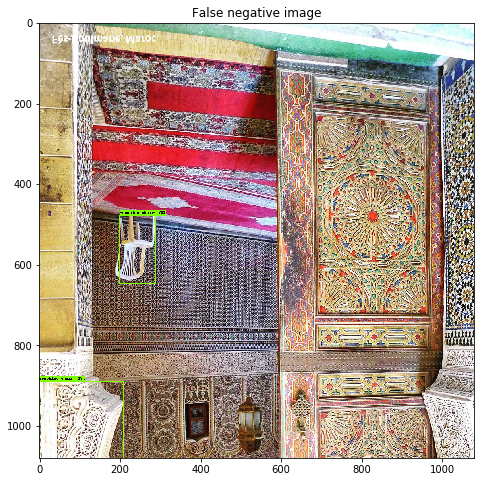

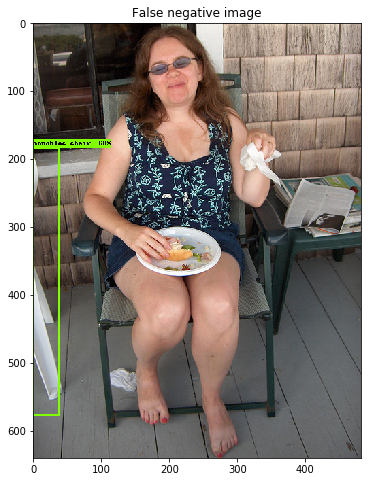

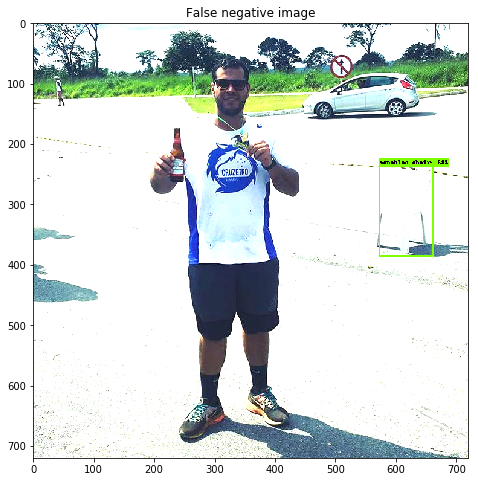

In [18]:
#To print the confusion matrix if an image contain a Monobloc chair
threshold=0.8
img_classifier(b_gt) 
tp, fn, fp, tn, error_path, error_reason = img_posneg(filenames,scores,boxes,b_gt,threshold)
print_pred(error_path,error_reason)

print("\n Confusion Matrix about 'Is there at least one monobloc in this image?' with threshold score>{} : \n Percentage of True Positive : {}% \n Percentage of False Positive : {}% \n Percentage of True Negative : {}% \n Percentage of False Negative : {}%".format(threshold,tp/(tp+fn+fp+tn)*100,fp/(tp+fn+fp+tn)*100,tn/(tp+fn+fp+tn)*100,fn/(tp+fn+fp+tn)*100))
print("Which means that {} images well predicted against {} miss predicted".format(tp+tn,fp+fn))

In [19]:
def img_graph(filenames,scores,boxes,b_gt):

    """
    Print false neg and false pos curves switchin several score threshold
    
    Parameters
    ----------
    filenames : List of string
    List of every image path contained in the validation set
    
    scores : List of list of float
    List of list of predicted scores
    
    boxes : List of list of dictionnaries
    List of list of Bounding boxes predicted, stocked in dictionnaries this way:
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
        
    b_gt : List of list of dictionnaries
    List of list of groundtruth bounding boxes, stocked in dictionnaries this way:
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    """
    
    thresholds=np.arange(0.2,1,0.05)
    list_fn=[]
    list_fp=[]
    both=[]
    
    for threshold in thresholds:
        tp, fn, fp, tn, caca, prout = img_posneg(filenames,scores,boxes,b_gt,threshold)
        list_fn.append(fn/len(filenames))
        list_fp.append(fp/len(filenames))
        both.append((fp+fn)/len(filenames))
    plt.figure(figsize=IMAGE_SIZE)
    plt.title("false positive(-.), false negative(--) and sum(line) curves according to several score thresholds")
    plt.xlabel("minimum score thresholds")
    plt.ylabel("number of false images in percent")
    plt.plot(thresholds, list_fn,'r--', thresholds, list_fp,'b-.', thresholds, both, 'g')
    plt.show()
    

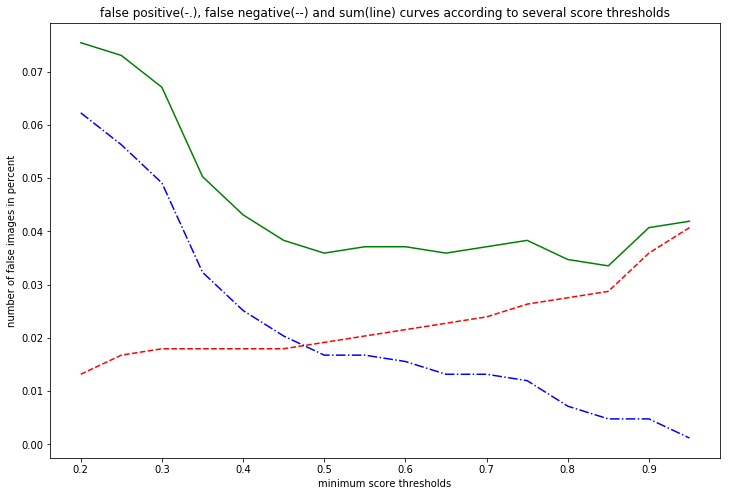

In [20]:
img_graph(filenames,scores,boxes,b_gt)